# Metropolis-Hastings algorithm

We present here a generic Metropolis-Hasting algorithm. The algorithm has the interesting feature of not needing the value of the normalization constant in the probability density function.

Take for example an exponential model: the distribution is for each $x$ proportional to $e^{-E(x)}$, where $E$ is some function. Then the distribution writes $\pi(x) = Z^{-1} e^{-E(x)}$, where $Z = \int e^{-E(x)} dx$ can be difficult to compute. The Metropolis Hastings algorithm can be used without knowing the value of $Z$.

Thanks to this feature, when modeling some random variable, one can use quite generic "energies" $E$ and efficiently simulate them.

We start by some imports

In [1]:
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
% matplotlib inline
% matplotlib notebook
import ipywidgets as widgets
from IPython.display import display

We define the necessary distributions. pi is the distribution that we want to sample. We use here a Gaussian distribution where V is the inverse of the covariance. q is the transition probability and prop is a function that proposes a transition. We use here the Random Walk Metropolis method, where the transitions are standard Gaussians.

In [2]:
def pi(x,V):
    '''
    Density of the target distribution, up to a constant. 
    
    x -- np array of size k
    V -- np array of size k*k
    '''
    return np.exp(-.5*np.dot(x,np.dot(V,x)))

In [3]:
def prop(x):
    '''
    Random proposition for the Metropolis-Hastings algorithm.
    Uses the Random Walk Metropolis formula with unit variance.
    
    x -- np array of size k
    '''
    return x + normal(size=len(x))

In [4]:
def q(x,y):
    '''
    Probability density of transition x to y, up to a constant.
    Uses the Random Walk Metropolis formula with unit variance.
    
    x -- np array of size k
    y -- np array of size k
    '''
    dist = x-y
    return np.exp(-.5*np.dot(dist,dist))

We will use some non-diagonal matrix V. The corresponding correlation is -0.9

In [5]:
example_V = np.array([[5.,4.5],[4.5,5.]])
display(example_V)
display(np.linalg.inv(example_V))

array([[ 5. ,  4.5],
       [ 4.5,  5. ]])

array([[ 1.05263158, -0.94736842],
       [-0.94736842,  1.05263158]])

In [6]:
np.linalg.inv(example_V)[1,0]/np.linalg.inv(example_V)[0,0]

-0.89999999999999991

Here's the density we want to simulate. Of course, in this 2-dimensional case it would be straightforward, but we use this as an educative example.

<IPython.core.display.Javascript object>


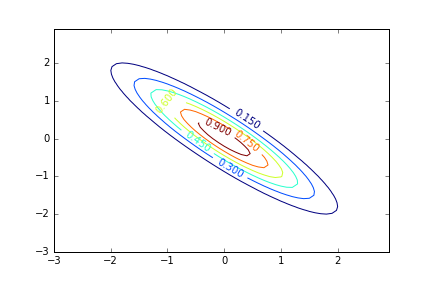

In [7]:
x = np.arange(-3.0, 3.0, 0.1)
y = np.arange(-3.0, 3.0, 0.1)
X, Y = np.meshgrid(x, y)
Z = np.array([[pi(np.array([X[i,j],Y[i,j]]),V=example_V) for j in range(len(X[0]))] for i in range(len(X))])
fig1 = plt.figure()
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10);

We implement the Metropolis-Hastings algorithm.

In [8]:
def MH(N,pi,q,prop,x0=np.zeros(2),V=np.identity(2)):
    x = x0
    trajectory = [x0]
    for i in range(1,N):
        y = prop(x)
        ratio = pi(y,V)*q(x,y)/pi(x,V)/q(y,x)
        a = np.min([1.,ratio])
        r = np.random.rand()
        if r < a:
            x = y
        trajectory += [x]
    return np.array(trajectory)

In [9]:
traj = MH(10000,pi,q,prop,V=example_V)

That's all for the simulation! Let's see what happens in the first few steps.

<IPython.core.display.Javascript object>


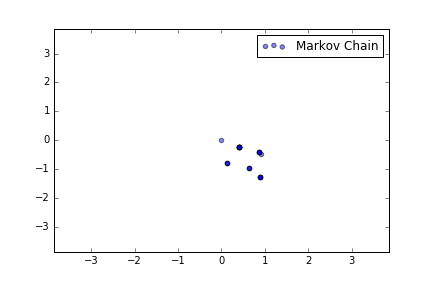

IntSlider(value=0)

Button(description=u'Advance', style=ButtonStyle())

In [44]:
def start_scatter_first(trajectory):
    fig = plt.figure()
    lim = np.max(np.abs(trajectory[:,]))
    plt.xlim((-lim, lim))
    plt.ylim((-lim, lim))
    plt.scatter(trajectory[:1,0],trajectory[:1,1],alpha=.5,label='Markov Chain')
    plt.legend(loc='best')
    plt.show()
    return fig

fig2 = start_scatter_first(traj)

def update_scatter_first(n,trajectory,figure):
    t = trajectory[:n]
    plt.figure(figure.number)
    pc1, = figure.axes[0].collections
    pc1.set_offsets(t)
    
def update_length_first(value):
    update_scatter_first(n=value['new'],trajectory=traj,figure=fig2)
    
slider_first = widgets.IntSlider(min=0,max=100,step=1)
display(slider_first)
slider_first.observe(update_length_first,names='value')
def incrementSlider(b):
    slider_first.value += 1
advanceButton = widgets.Button(value=False,description='Advance')
display(advanceButton)
advanceButton.on_click(incrementSlider)

As you should see above, sometimes pressing 'advance' doesn't create a new point. This means the proposition has been rejected. Instead, the current point increases in darkness. The efficiency of the sampling algorithm depends in part of that effect: if the propositions are too spread out, they will be often rejected. However, if they are too concentrated, the samples will be correlated and the algorithm may take more time to explore the whole state space.

When one wants to sample independently from pi, one can choose to keep only every few Markov Chain values. Here we will take every 10 values. The initialization is not included in the independent sample.

In [11]:
def split_trajectory(trajectory,freq):
    trajectory1,trajectory2 = [trajectory[0]],[]
    for i in range(1,len(trajectory)):
        if i%freq == 0:
            trajectory2 += [trajectory[i,:]]
        else:
            trajectory1 += [trajectory[i,:]]
    return np.array(trajectory1),np.array(trajectory2)

In [12]:
traj1,traj2 = split_trajectory(traj,50)

Let's continue with plotting the simulations. We will plit in blue the Markov Chain and in red the points that we'd like to keep to get an approximately independent sample. We will use here an animation iPython widget - you just have to click play.

In [13]:
def start_scatter(trajectory1, trajectory2, freq, title='Simulations using RWM Metropolis-Hastings'):
    fig = plt.figure()
    lim = np.max(np.append(np.abs(trajectory1[:,]),np.abs(trajectory2)))
    plt.xlim((-lim, lim))
    plt.ylim((-lim, lim))
    plt.scatter(trajectory1[:freq,0],trajectory1[:freq,1],alpha=.01,label='Markov Chain')
    plt.scatter(trajectory2[0,0],trajectory2[0,1],color='red',alpha=.5,label='Approx. ind. sample')
    plt.title(title)
    plt.legend(loc='best')
    plt.show()
    return fig

def update_scatter(n,trajectory1,trajectory2,freq,figure):
    t1 = trajectory1[:(n - n / freq)]
    t2 = trajectory2[:(n / freq)]
    plt.figure(figure.number)
    pc1, pc2 = figure.axes[0].collections
    pc1.set_offsets(t1)
    pc2.set_offsets(t2)
    
def update_length(value):
    update_scatter(n=value['new'],trajectory1=traj1,trajectory2=traj2,freq=freq3,figure=fig3)    
    
#For those who will look deeper into the code, this isn't very proper coding -
#we use the fact that the notebook treats basically all variables as global and
#that you can use undeclared variables inside function definitions.

<IPython.core.display.Javascript object>


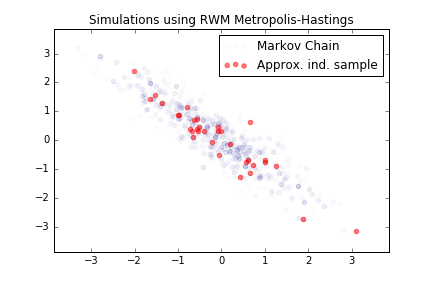

IntSlider(value=0, max=10000, step=50)

Play(value=50, max=10000, step=50)

In [14]:
freq3 = 50

fig3 = start_scatter(traj1,traj2,freq3)

play3 = widgets.Play(value=50,min=0,max=len(traj),step=freq3)
slider3 = widgets.IntSlider(min=play3.min,max=play3.max,step=freq3)
widgets.jslink((play3,'value'),(slider3,'value'))
display(slider3,play3)
slider3.observe(update_length,names='value')

Let us verify now whether the red samples are approximately independent. Given that the expectations are null, we get the empirical covariance using this simple calculation:

In [15]:
np.dot(traj2[:-1].T,traj2[1:])/(1.*len(traj2)-1.)

array([[ 0.09863284, -0.06156139],
       [-0.07949579,  0.01295959]])

We can generalize the above in several ways. First, we will introduce several other transition densities.

RWM stands for the Random Walk Metropolis algorithm, used above, to which we add an optional argument for the variance of the propositions.

PCN stands for Preconditioned Crank-Nicholson, where the proposition is distributed according to a normal distribution (the variance can be chosen by the user) around $\rho x$, where $\rho$ can be chosen between $0$ and $1$ and $x$ is the last position of the Markov Chain. 

MALA stands for Metropolis Accelerated Langevin Algorithm. In addition to the optional propostion variance $\sigma$ the speed of gradient descent $\eta$, one needs to provide a gradient function $grad$. We will provide tehgradient function for the Gaussian distribution.

In [16]:
def prop_rwm(x,sig=1.):
    '''
    Generalisaion of the RWM proposition function.
    
    x -- np array of size k
    sig -- standard deviation of the proposition
    '''
    return x + normal(scale=sig,size=len(x))

In [17]:
def prop_pcn(x,rho=.5,sig=1.):
    '''
    Preconditioned Crank-Nicholson proposition function.
    
    x -- np array of size k
    rho -- real number in (0,1)
    sig -- standard deviation of the proposition
    '''
    return rho*x + normal(scale=sig,size=len(x))

In [18]:
def prop_mala(x,grad,eta=1.,sig=1.):
    '''
    Metropolis Accelerated Langevin Algorithm proposition function.
    
    x -- np array of size k
    grad -- gradient of log(pi)
    eta -- gradient following speed
    sig -- standard deviation of the proposition
    '''
    return x - eta*grad(x) + normal(scale=sig,size=len(x))

In [19]:
def prop_choice(x,algo='rwm',**kwargs):
    if algo.upper() == 'RWM':
        newargs = {k:kwargs[k] for k in ('sig') if k in kwargs}
        return prop_rwm(x,**newargs)
    elif algo.upper() == 'PCN':
        newargs = {k:kwargs[k] for k in ('rho','sig') if k in kwargs}
        return prop_pcn(x,**newargs)
    elif algo.upper() == 'MALA':
        newargs = {k:kwargs[k] for k in ('grad','eta','sig') if k in kwargs}
        return prop_mala(x,**newargs)
    else:
        print('Algorithm not recoginzed. Choose between RWM, PCN and MALA.')
        return 0.

In [20]:
def q_rwm(x,y,sig=1.):
    '''
    Probability density of transition x to y, up to a constant, for the RWM setting.
    
    x -- np array of size k
    y -- np array of size k
    '''
    dist = x-y
    return np.exp(-.5*np.dot(dist,dist)/(sig**2))

In [21]:
def q_pcn(x,y,rho=.5,sig=1.):
    '''
    Probability density of transition x to y, up to a constant, for the PCN setting.
    
    x -- np array of size k
    y -- np array of size k
    '''
    dist = rho*x-y
    return np.exp(-.5*np.dot(dist,dist)/(sig**2))

In [22]:
def q_mala(x,y,grad,eta=1.,sig=1.):
    '''
    Probability density of transition x to y, up to a constant, for the MALA setting.
    
    x -- np array of size k
    grad -- gradient of log(pi)
    eta -- gradient following speed
    sig -- standard deviation of the proposition
    '''
    dist = y - x + eta*grad(x)
    return np.exp(-.5*np.dot(dist,dist)/(sig**2))

In [23]:
def q_choice(x,y,algo='rwm',**kwargs):
    if algo.upper() == 'RWM':
        newargs = {k:kwargs[k] for k in ('sig') if k in kwargs}
        return q_rwm(x,y,**newargs)
    elif algo.upper() == 'PCN':
        newargs = {k:kwargs[k] for k in ('rho','sig') if k in kwargs}
        return q_pcn(x,y,**newargs)
    elif algo.upper() == 'MALA':
        newargs = {k:kwargs[k] for k in ('grad','eta','sig') if k in kwargs}
        return q_mala(x,y,**newargs)
    else:
        print('Algorithm not recoginzed. Choose between RWM, PCN and MALA.')
        return 0.

Second, one of the advantages of the Metropolis Hastings algorithm is that the you don't need to know the normalisation constant of the distribution from which you want to sample. From a modeling point of view, you can specify simply an energy $E$ which is lowest at the spots that you want the most likely and assume $\pi \propto e^{-E}$. Furhtermore, writing the distribution in that way makes the implementation of MALA straightforward, as you only need to compute the gradient of $E$.

In [24]:
def pi_energy(x,E,**E_args):
    return np.exp(-E(x,**E_args))

Here we provide an extension of the MH algorithm, where one can choose the distribution and the procedure. It also integrates a progress bar that will come handy later on.

In [25]:
def MetropolisHastings(N,pi,algo='RWM',x0=np.zeros(2),**kwargs):
    progressBar = kwargs.pop('progressBar',None)
    b = progressBar is not None
    if b:
        progressBar.value = 0
    x = x0
    trajectory = [x0]
    for i in range(1,N):
        if b and i%freqIntText.value == 0:
            progressBar.value += freqIntText.value
        y = prop_choice(x,algo=algo,**kwargs)
        ratio = pi(y)*q_choice(x,y,algo=algo,**kwargs)/pi(x)/q_choice(y,x,algo=algo,**kwargs)
        a = np.min([1.,ratio])
        r = np.random.rand()
        if r < a:
            x = y
        trajectory += [x]
    if b:
        progressBar.value = freqIntText.max
    return np.array(trajectory)

We continue with creating an environment where you can easily choose the algorithm, the distribution to sample from and show the results. We provide three example distributions which you can easily tweak, or add new ones.

In [26]:
def E_gauss(x, mean, V):
    '''
    Energy for the Gaussian distribution.
    
    x -- numpy array (k,1)
    mean -- numpy array (k,1)
    V -- numpy array (k,k)
    '''
    dist = x - mean
    return .5*np.dot(dist,np.dot(V,dist))

In [27]:
def grad_gauss(x,mean,V):
    dist = x - mean
    return np.dot(V,dist)

In [28]:
def E_multipleValley(x,mean_list,V_list):
    '''
    Product of multiple Gaussian energies. Creates an energy valley at every mean in mean_list. This is *not* a Gaussian mixture.
    '''
    return np.prod([E_gauss(x,mean,V) for (mean,V) in zip(mean_list,V_list)])

In [29]:
def grad_multipleValley(x,mean_list,V_list):
    l = len(mean_list)
    dist_list = [x-mean for mean in mean_list]
    s = np.zeros(len(x))
    for i in range(l):
        e = E_multipleValley(x,[mean_list[j] for j in range(l) if j != i],[V_list[j] for j in range(l) if j != i])
        s += e*np.dot(V_list[i],dist_list[i])
    return s

This example builds on the first one and provides a non-trivial correlation. The non-triial mean will show how the algorithm reacts to an initialization away from the energy valley. You can experiment with putting the mean even farther away from the origin.

In [30]:
def E_example1(x):
    return E_gauss(x,np.ones(2),np.array([[5.,4.5],[4.5,5.]]))

<IPython.core.display.Javascript object>


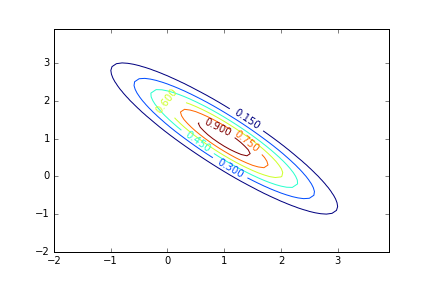

In [31]:
x = np.arange(-2.0, 4.0, 0.1)
y = np.arange(-2.0, 4.0, 0.1)
X, Y = np.meshgrid(x, y)
Z = np.array([[pi_energy(np.array([X[i,j],Y[i,j]]),E_example1) for j in range(len(X[0]))] for i in range(len(X))])
plt.figure()
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10);

This example uses two energy valleys, at $(1,1)$ and $(-1,-1)$. Intuitively, the Markov Chain tends to stay inside the energy valleys and may have trouble leaving one valley to explore the second one -  this is a common issue with energies that are non-convex. To observe that, you can experiment with means that are placed farther away from each other, as well as with the algorithm parameters. 

In [32]:
def E_example2(x):
    return E_multipleValley(x,[np.ones(2),-np.ones(2)],[np.identity(2),np.identity(2)])

<IPython.core.display.Javascript object>


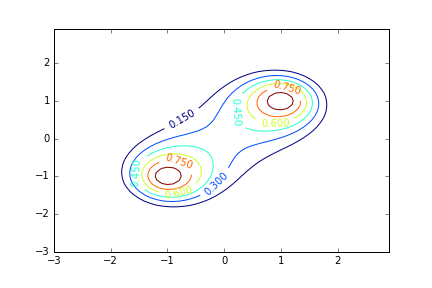

In [33]:
x = np.arange(-3.0, 3.0, 0.1)
y = np.arange(-3.0, 3.0, 0.1)
X, Y = np.meshgrid(x, y)
Z = np.array([[pi_energy(np.array([X[i,j],Y[i,j]]),E_example2) for j in range(len(X[0]))] for i in range(len(X))])
plt.figure()
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10);

Developing on the previous example, we use here 4 energy valleys. As the energy is increasing as $x^8$ away from the valleys, the samples are extremely unlikely at longer distances.

In [34]:
def E_example3(x):
    return E_multipleValley(x,[np.ones(2),-np.ones(2),np.array([-1.,1.]),np.array([1.,-1.])],[np.identity(2),np.identity(2),np.identity(2),np.identity(2)])

<IPython.core.display.Javascript object>


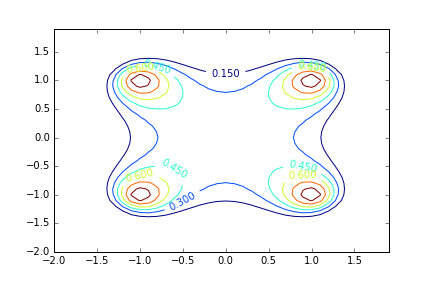

<a list of 10 text.Text objects>

In [35]:
x = np.arange(-2.0, 2.0, 0.1)
y = np.arange(-2.0, 2.0, 0.1)
X, Y = np.meshgrid(x, y)
Z = np.array([[pi_energy(np.array([X[i,j],Y[i,j]]),E_example3) for j in range(len(X[0]))] for i in range(len(X))])
plt.figure()
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10);

In [36]:
def piChoice(i):
    if i == 1:
        return lambda x: pi_energy(x,E_example1)
    elif i == 2:
        return lambda x: pi_energy(x,E_example2)
    else:
        return lambda x: pi_energy(x,E_example3)

In [37]:
def gradChoice(i):
    if i == 1:
        return lambda x: grad_gauss(x,np.ones(2),np.array([[5.,4.5],[4.5,5.]]))
    elif i == 2:
        return lambda x: grad_multipleValley(x,[np.ones(2),-np.ones(2)],[np.identity(2),np.identity(2)])
    else:
        return lambda x: grad_multipleValley(x,[np.ones(2),-np.ones(2),np.array([-1.,1.]),np.array([1.,-1.])],[np.identity(2),np.identity(2),np.identity(2),np.identity(2)])

In [38]:
def algoChoice(i):
    d = {1:'RWM',2:'PCN',3:'MALA'}
    return d[i]

The following provides functions that we will use to plot the results and is not mathematically interesting. However, you could be interested if you want to see how ipywidgets work.

In [39]:
def initialize_scatter(figNum, trajectory1, trajectory2, freq, title='Simulations using RWM Metropolis-Hastings'):
    #sliderFinal.value = freq
    fig = plt.figure(figNum)
    plt.clf()
    lim = np.max(np.append(np.abs(trajectory1[:,]),np.abs(trajectory2)))
    plt.xlim((-lim, lim))
    plt.ylim((-lim, lim))
    plt.scatter(trajectory1[:freq,0],trajectory1[:freq,1],alpha=.01,label='Markov Chain')
    plt.scatter(trajectory2[0,0],trajectory2[0,1],color='red',alpha=.5,label='Approx. ind. sample')
    plt.title(title)
    plt.legend(loc='best')
    return fig

In [40]:
trajFinal1, trajFinal2 = np.array([]), np.array([])
def runSimulation(on_press):
    global trajFinal, trajFinal1, trajFinal2
    pi = piChoice(exampleDropdown.value)
    algo = algoChoice(algoDropdown.value)
    grad = gradChoice(exampleDropdown.value)
    trajectory = MetropolisHastings(lengthIntText.value,pi,algo,grad=grad,eta=etaFloatText.value,rho=rhoBoundedFloatText.value,progressBar=simulationProgress)
    trajFinal1,trajFinal2 = split_trajectory(trajectory,freqIntText.value)
    title = 'Simulations using '+ algo
    
    initialize_scatter(figFinal.number,trajFinal1,trajFinal2, freqIntText.value, title)

Here, we define the widgets that we use for the illustration: you can safely skip it.

In [41]:
algoDropdown = widgets.Dropdown(
    options={'RWM': 1, 'PCN': 2, 'MALA': 3},
    value=1,
    description='Algorithm:'
)

exampleDropdown = widgets.Dropdown(
    options={'Correlation': 1, 'Double Valley': 2, 'Quadruple valley': 3},
    value=1,
    description='Example:'
)

lengthIntText = widgets.IntText(
    value=10000,
    description='Simulation length:',
    disabled=False
)

freqIntText = widgets.BoundedIntText(
    value=100,
    min=1,
    max= lengthIntText.value,
    description='Independent sample frequency:',
    disabled=False
)

sigFloatText = widgets.FloatText(
    value=1.,
    step=.1,
    description='Volatility value:',
    disabled=False
)

rhoBoundedFloatText = widgets.BoundedFloatText(
    value=.5,
    min=0.,
    max=1.0,
    step=0.05,
    description='Correlation value:',
    disabled=False
)

etaFloatText = widgets.FloatText(
    value=.1,
    step=.01,
    description='Gradient coefficient:',
    disabled=False
)

runButton = widgets.Button(
    value=False,
    description='Run!',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Run!',
    icon='check'
)

simulationProgress = widgets.IntProgress(
    value=0,
    min=0,
    max=lengthIntText.value,
    step=freqIntText.value,
    description='Simulation:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal'
)

The following widget code displays the simulation interface. You can choose the algorithm, the example distribution from which you sample and most parameters of the simulation. Run the simulation by clicking 'Run' and display the scatter using the play button or the slider.

Dropdown(description=u'Algorithm:', index=1, options={'PCN': 2, 'RWM': 1, 'MALA': 3}, value=1)

Dropdown(description=u'Example:', index=2, options={'Quadruple valley': 3, 'Double Valley': 2, 'Correlation': 1}, value=1)

IntText(value=10000, description=u'Simulation length:')

BoundedIntText(value=100, description=u'Independent sample frequency:', max=10000, min=1)

FloatText(value=1.0, description=u'Volatility value:', step=0.1)

For Preconditioned Crank-Nicolson:


BoundedFloatText(value=0.5, description=u'Correlation value:', max=1.0, step=0.05)

For Metropolis Accelerated Langevin Algorithm:


FloatText(value=0.1, description=u'Gradient coefficient:', step=0.01)

Button(description=u'Run!', icon=u'check', style=ButtonStyle(), tooltip=u'Run!')

IntProgress(value=0, description=u'Simulation:', max=10000)

<IPython.core.display.Javascript object>


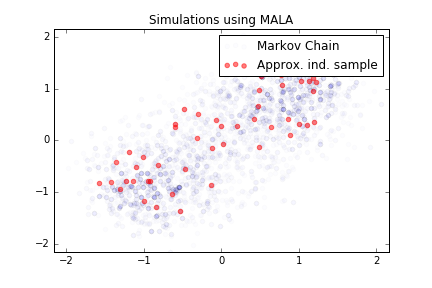

IntSlider(value=0, max=10000, step=100)

Play(value=0, max=10000, step=100)

In [42]:
display(algoDropdown,exampleDropdown,lengthIntText,freqIntText,sigFloatText)
print('For Preconditioned Crank-Nicolson:')
display(rhoBoundedFloatText)
print('For Metropolis Accelerated Langevin Algorithm:')
display(etaFloatText)

display(runButton,simulationProgress)

figFinal = plt.figure()
playFinal = widgets.Play(value=0, min=0, max=lengthIntText.value, step=freqIntText.value, disabled=False)
sliderFinal = widgets.IntSlider(min=playFinal.min,max=playFinal.max,step=playFinal.step)
widgets.jslink((playFinal, 'value'), (sliderFinal, 'value'))
display(sliderFinal,playFinal)
def update_len_Final(value):
    update_scatter(n=value['new'],trajectory1=trajFinal1,trajectory2=trajFinal2,freq=freqIntText.value,figure=figFinal)
sliderFinal.observe(update_len_Final,names='value')
runButton.on_click(runSimulation)

The blue points are stored in trajFinal1. The red ones in trajFinal2. They are overwritten each time you click 'Run'.

In [43]:
trajFinal2[:10]

array([[ 2.40389972, -0.17372928],
       [ 2.64884268, -0.41837283],
       [ 0.70887711,  1.50195868],
       [ 1.31392305,  0.60715091],
       [ 0.82980684,  1.35528777],
       [ 1.64339009,  0.32202994],
       [-0.867416  ,  2.95255314],
       [ 1.41482012, -0.07495228],
       [ 2.10033652,  0.51128275],
       [ 2.12508447, -0.07961537]])